In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
%matplotlib inline

In [2]:
# Load data
infile = open('whiskeys.pkl','rb')
my_list = pickle.load(infile)
infile.close()

## Data Cleaning and EDA

In [3]:
df = pd.DataFrame(my_list)
df.head()

,whiskey_name,rating,rating_source,user_rating,num_reviews,price,brand,country,state,spirit_type,taste
0,Method & Madness Single Grain Whisky,NaN,None,5.0,2.0,59.99,Method & Madness,Ireland,None,Irish Whiskey,"[Rich, Oak, Grain, Balanced]"
1,Shieldaig Islay Single Malt,NaN,None,3.7,178.0,21.99,Shieldaig,Scotland,Islay & Islands,Scotch,"[Rich, Peat, Smoke, Balanced]"
2,Riverboat Rye Whiskey,NaN,None,3.8,40.0,19.99,Riverboat,United States,Indiana,American Whiskey,"[Intense, Spice, Toast, Balanced]"
3,Whistlepig 10 Year Private Rye Barrel Select,96.0,Wine Enthusiast,4.6,14.0,91.99,WhistlePig,United States,Vermont,American Whiskey,"[Rich, Caramel, Vanilla, Spice, Long]"
4,Highland Queen Majesty Sauternes Finish Single...,NaN,None,4.1,22.0,17.99,Highland Queen Majesty,Scotland,Highland,Scotch,"[Medium, Vanilla, Cherry, Balanced]"


In [4]:
df.shape

(1199, 11)

We can see that there are 1199 entries for the 11 columns we scraped for our data set, but let's also check for duplicates based on the name of the whiskey since other columns containing information on the brand, country, etc. are likely to have repeating values that aren't actually duplicates.

In [5]:
# find the number of duplicate bottles
df.duplicated(subset='whiskey_name').sum()

1

In [6]:
# find the duplicate value
df[df.duplicated(subset='whiskey_name') == True]

,whiskey_name,rating,rating_source,user_rating,num_reviews,price,brand,country,state,spirit_type,taste
609,Select Club Apple Whisky,NaN,None,3.5,2.0,25.99,Texas Select Club,Canada,None,Canadian Whisky,"[Light, Apple, Sweet, Spice, Long]"


In [7]:
# remove the duplicate
df.drop_duplicates(subset='whiskey_name', inplace=True)

In [8]:
df.shape

(1198, 11)

In the `whiskey_name` column, we see that for whiskeys that include an apostrophe and an *s* in the title, the *s* is capitalized. We can change that so that the bottle name is titled correctly.

In [9]:
df['whiskey_name'] = df['whiskey_name'].str.replace("'S", "'s")
df.head()

,whiskey_name,rating,rating_source,user_rating,num_reviews,price,brand,country,state,spirit_type,taste
0,Method & Madness Single Grain Whisky,NaN,None,5.0,2.0,59.99,Method & Madness,Ireland,None,Irish Whiskey,"[Rich, Oak, Grain, Balanced]"
1,Shieldaig Islay Single Malt,NaN,None,3.7,178.0,21.99,Shieldaig,Scotland,Islay & Islands,Scotch,"[Rich, Peat, Smoke, Balanced]"
2,Riverboat Rye Whiskey,NaN,None,3.8,40.0,19.99,Riverboat,United States,Indiana,American Whiskey,"[Intense, Spice, Toast, Balanced]"
3,Whistlepig 10 Year Private Rye Barrel Select,96.0,Wine Enthusiast,4.6,14.0,91.99,WhistlePig,United States,Vermont,American Whiskey,"[Rich, Caramel, Vanilla, Spice, Long]"
4,Highland Queen Majesty Sauternes Finish Single...,NaN,None,4.1,22.0,17.99,Highland Queen Majesty,Scotland,Highland,Scotch,"[Medium, Vanilla, Cherry, Balanced]"


Next, we'll check for null values and drop any `NaN` values from columns that will later be continuous features.

In [10]:
df.isnull().sum()

whiskey_name        0
rating           1063
rating_source    1063
user_rating       538
num_reviews        16
price              43
brand               0
country             0
state             243
spirit_type         0
taste              53
dtype: int64

In [11]:
df.dropna(subset=['user_rating', 'num_reviews', 'price'], inplace=True)
df.shape

(648, 11)

We can also fill `NaN` values with 0 from columns that will later be categorical features.

In [12]:
values = {'rating_source':0, 'state':0, 'taste':0}
df.fillna(value=values, inplace=True)
df.isnull().sum()

whiskey_name       0
rating           522
rating_source      0
user_rating        0
num_reviews        0
price              0
brand              0
country            0
state              0
spirit_type        0
taste              0
dtype: int64

In [13]:
df.head()

,whiskey_name,rating,rating_source,user_rating,num_reviews,price,brand,country,state,spirit_type,taste
0,Method & Madness Single Grain Whisky,NaN,0,5.0,2.0,59.99,Method & Madness,Ireland,0,Irish Whiskey,"[Rich, Oak, Grain, Balanced]"
1,Shieldaig Islay Single Malt,NaN,0,3.7,178.0,21.99,Shieldaig,Scotland,Islay & Islands,Scotch,"[Rich, Peat, Smoke, Balanced]"
2,Riverboat Rye Whiskey,NaN,0,3.8,40.0,19.99,Riverboat,United States,Indiana,American Whiskey,"[Intense, Spice, Toast, Balanced]"
3,Whistlepig 10 Year Private Rye Barrel Select,96.0,Wine Enthusiast,4.6,14.0,91.99,WhistlePig,United States,Vermont,American Whiskey,"[Rich, Caramel, Vanilla, Spice, Long]"
4,Highland Queen Majesty Sauternes Finish Single...,NaN,0,4.1,22.0,17.99,Highland Queen Majesty,Scotland,Highland,Scotch,"[Medium, Vanilla, Cherry, Balanced]"


Now that our data is cleaned, we'll observe how the different features are related to one another, first in a heatmap and then in a pairplot.

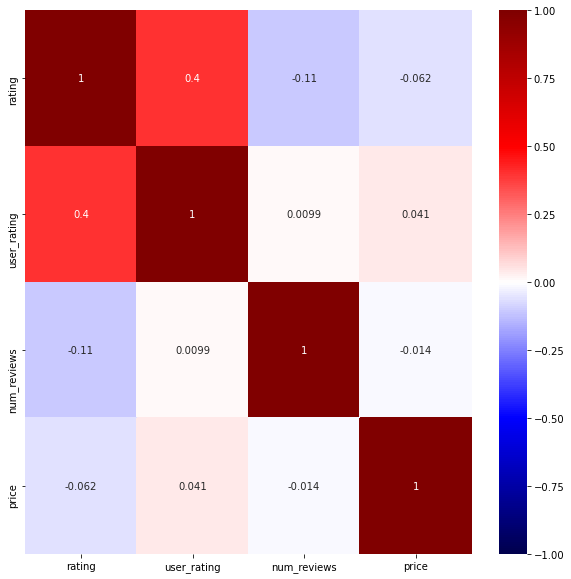

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), cmap="seismic", vmin=-1, vmax=1, annot=True, ax=ax);

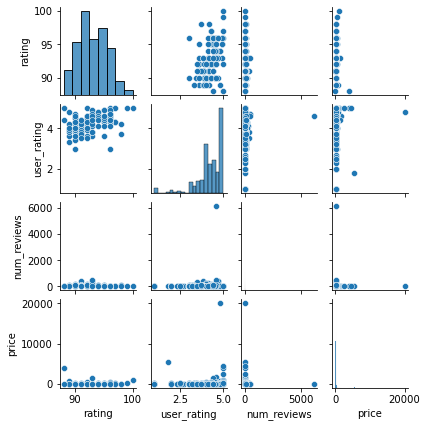

In [15]:
sns.pairplot(df, height=1.5, aspect=1);

We can see that our data has some outliers that may affect our model, specifically with respect to price. We'll first look at the average price of a whiskey and the standard deviation. After, we can sort the values and remove any outliers to see if we can improve the correlation between features.

In [16]:
df.describe()

,rating,user_rating,num_reviews,price
count,126.000000,648.000000,648.000000,648.000000
mean,92.896825,4.255093,31.470679,140.636574
std,2.538754,0.771681,246.057329,857.099432
min,88.000000,1.000000,1.000000,6.990000
25%,91.000000,4.000000,2.000000,25.990000
50%,93.000000,4.400000,5.000000,47.240000
75%,95.000000,5.000000,19.000000,80.490000
max,100.000000,5.000000,6152.000000,19999.990000


The average price for a bottle of whiskey is about \\$140 with a standard deviation of about $857. Looking below at the dataframe, it may be helpful to remove bottles with a value over \\$1000.

In [17]:
df.sort_values(by=['price'], ascending=False).head(10)

,whiskey_name,rating,rating_source,user_rating,num_reviews,price,brand,country,state,spirit_type,taste
462,Duncan Taylor Macallan Rarest 1969 With Glasses,NaN,0,4.8,4.0,19999.99,Macallan,Scotland,Highland,Scotch,"[Rich, Fruit, Orange, Complex]"
54,"Macallan ""M"" Crystal Decanter",NaN,0,1.8,4.0,5499.99,Macallan,Scotland,0,Scotch,"[Rich, Dried Fruit, Vanilla, Spice, Long]"
912,Glenfiddich 1978 Vintage Cask,NaN,0,5.0,2.0,4499.99,Glenfiddich,Scotland,Speyside,Scotch,"[Rich, Fruit, Vanilla, Oak, Long]"
165,Macallan Fine Oak 30 Yr,88.0,Whisky Advocate,5.0,1.0,3899.99,Macallan,Scotland,Highland,Scotch,"[Rich, Dried Fruit, Orange, Wood, Long]"
527,Brora 38 Yr,NaN,0,5.0,1.0,2399.99,Brora,Scotland,0,Scotch,"[Intense, Salt, Smoke, Peat, Long]"
25,Macallan 25 Yr,NaN,0,4.6,14.0,1598.99,Macallan,Scotland,Highland,Scotch,"[Rich, Fruit, Smoke, Long]"
142,Balvenie 30 Yr,93.0,Whisky Advocate,4.4,8.0,1399.99,Balvenie,Scotland,0,Scotch,"[Intense, Oak, Spice, Balanced]"
126,Dalmore 25 Yr,NaN,0,5.0,1.0,999.99,Dalmore,Scotland,0,Scotch,"[Medium, Floral, Citrus, Toffee, Balanced]"
471,Laphroaig 30 Yr,NaN,0,5.0,1.0,959.99,Laphroaig,Scotland,Islay & Islands,Scotch,"[Medium, Wood, Vanilla, Smoke, Complex]"
186,Highland Park 25 Yr,100.0,Ultimate Spirits Challenge,5.0,4.0,899.99,Highland Park,Scotland,Islay & Islands,Scotch,"[Intense, Oak, Spice, Peat, Long]"


In [18]:
df.drop(df[df.price > 1000].index, inplace=True)
df.describe()

,rating,user_rating,num_reviews,price
count,124.000000,641.000000,641.000000,641.000000
mean,92.935484,4.253822,31.761310,80.863604
std,2.520620,0.767660,247.383048,111.368432
min,88.000000,1.000000,1.000000,6.990000
25%,91.000000,4.000000,2.000000,25.490000
50%,93.000000,4.400000,5.000000,46.990000
75%,95.000000,5.000000,19.000000,79.990000
max,100.000000,5.000000,6152.000000,999.990000


Now let's look at our plots again.

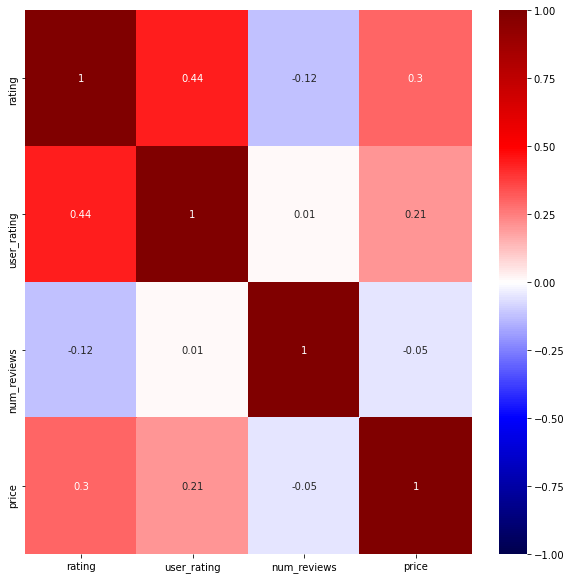

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), cmap="seismic", vmin=-1, vmax=1, annot=True, ax=ax);
#plt.savefig('heatmap.svg')

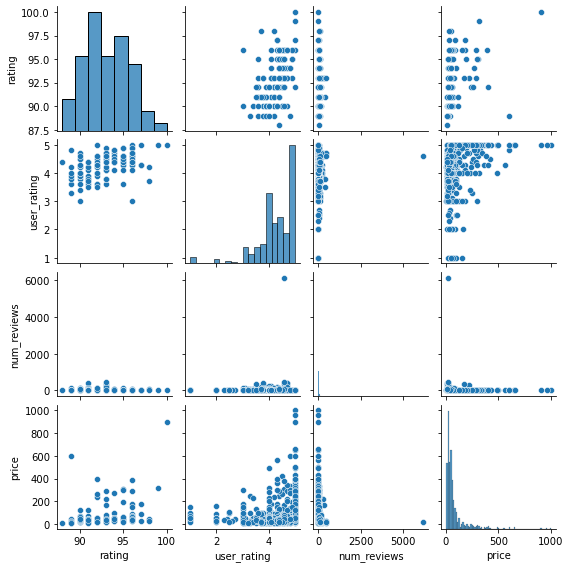

In [20]:
sns.pairplot(df, height=2, aspect=1);
#plt.savefig('pairplot.svg')

In [21]:
df.describe()

,rating,user_rating,num_reviews,price
count,124.000000,641.000000,641.000000,641.000000
mean,92.935484,4.253822,31.761310,80.863604
std,2.520620,0.767660,247.383048,111.368432
min,88.000000,1.000000,1.000000,6.990000
25%,91.000000,4.000000,2.000000,25.490000
50%,93.000000,4.400000,5.000000,46.990000
75%,95.000000,5.000000,19.000000,79.990000
max,100.000000,5.000000,6152.000000,999.990000


In [22]:
df1 = df
#df1['brand_counts'] = df.groupby(df.brand).transform('count')

In [23]:
df1['brand_counts'] = df1.groupby('brand')['brand'].transform('count')

In [24]:
df1.sort_values(by='brand_counts', ascending=False, inplace=True)
df1.head(30)

,whiskey_name,rating,rating_source,user_rating,num_reviews,price,brand,country,state,spirit_type,taste,brand_counts
620,Battlehill Islay Malt 16 Yr,NaN,0,4.0,1.0,149.99,Battlehill,Scotland,Islay & Islands,Scotch,"[Medium, Citrus, Smoke, Medicinal, Long]",25
871,Battlehill Glentauchers 11 Yr,NaN,0,4.0,1.0,69.99,Battlehill,Scotland,Speyside,Scotch,"[Delicate, Nut, Oak, Fruit, Long]",25
1068,Battlehill Miltonduff 8 Yr,NaN,0,4.0,1.0,54.99,Battlehill,Scotland,Speyside,Scotch,"[Rich, Sherry, Citrus, Balanced]",25
488,Battlehill Clynelish 19,NaN,0,5.0,2.0,149.99,Battlehill,Scotland,Highland,Scotch,"[Medium, Tropical Fruit, Sweet, Mild]",25
996,Battlehill Cragganmore 22 Yr,NaN,0,5.0,1.0,179.99,Battlehill,Scotland,Speyside,Scotch,"[Medium, Pear, Honey, Balanced]",25
989,Battlehill Royal Brackla 5 Yr,NaN,0,4.0,2.0,44.99,Battlehill,Scotland,Speyside,Scotch,"[Light, Vanilla, Sherry, Spice, Complex]",25
984,Battlehill Bunnahabhain 6Yr,NaN,0,5.0,1.0,56.99,Battlehill,Scotland,Islay & Islands,Scotch,"[Medium, Smoke, Caramel, Fruit, Complex]",25
969,Battlehill Fettercairn 7 Yr,NaN,0,5.0,1.0,59.99,Battlehill,Scotland,Highland,Scotch,"[Medium, Honey, Creamy, Balanced]",25
956,Battlehill Craigellachie 8 Yr,NaN,0,4.0,2.0,64.99,Battlehill,Scotland,Speyside,Scotch,"[Delicate, Citrus, Grass, Mild]",25
610,Battlehill Ardmore Peated 10 Yr,NaN,0,5.0,1.0,69.99,Battlehill,Scotland,Highland,Scotch,"[Medium, Peat, Smoke, Lemon, Complex]",25


Text(0.5, 1.0, 'Plot of Counts for Number of Bottles Produced Per Brand')

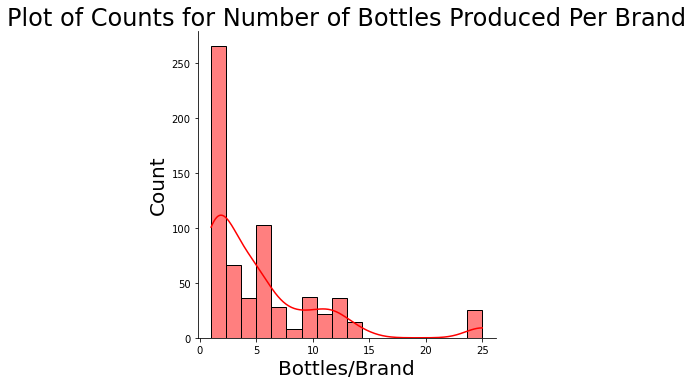

In [25]:
g = sns.displot(data=df1, x="brand_counts", kde=True, color="red")
plt.xlabel("Bottles/Brand", size=20)
plt.ylabel("Count", size=20)
plt.title("Plot of Counts for Number of Bottles Produced Per Brand", size=24)
#g.set(xticks=[])
#g.set_xticklabels(rotation=45)
#plt.savefig('brand_frequency.svg')

#### Challenge 1
Build a linear model that uses only a constant term (a column of ones) to predict a continuous outcome (like domestic total gross). How can you interpret the results of this model? What does it predict? Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed?

In [26]:
df['target_mean'] = df['user_rating'].mean()
df.head()

,whiskey_name,rating,rating_source,user_rating,num_reviews,price,brand,country,state,spirit_type,taste,brand_counts,target_mean
620,Battlehill Islay Malt 16 Yr,NaN,0,4.0,1.0,149.99,Battlehill,Scotland,Islay & Islands,Scotch,"[Medium, Citrus, Smoke, Medicinal, Long]",25,4.253822
871,Battlehill Glentauchers 11 Yr,NaN,0,4.0,1.0,69.99,Battlehill,Scotland,Speyside,Scotch,"[Delicate, Nut, Oak, Fruit, Long]",25,4.253822
1068,Battlehill Miltonduff 8 Yr,NaN,0,4.0,1.0,54.99,Battlehill,Scotland,Speyside,Scotch,"[Rich, Sherry, Citrus, Balanced]",25,4.253822
488,Battlehill Clynelish 19,NaN,0,5.0,2.0,149.99,Battlehill,Scotland,Highland,Scotch,"[Medium, Tropical Fruit, Sweet, Mild]",25,4.253822
996,Battlehill Cragganmore 22 Yr,NaN,0,5.0,1.0,179.99,Battlehill,Scotland,Speyside,Scotch,"[Medium, Pear, Honey, Balanced]",25,4.253822


In [27]:
# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df[['target_mean']]

# Choose the response variable(s)
y = df[['user_rating']]

# Fit the model to the full dataset
fit1 = lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.0

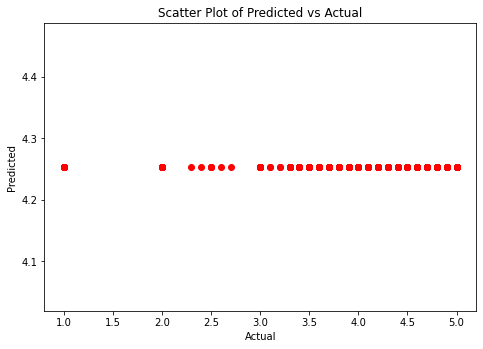

In [28]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(y, lr.predict(X), color='r')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Scatter Plot of Predicted vs Actual')
plt.show()

<AxesSubplot:ylabel='Count'>

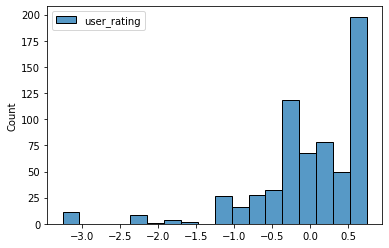

In [29]:
y_residuals = df[['user_rating']] - lr.predict(X)
sns.histplot(data=y_residuals)

#### Challenge 2
Repeat the process of challenge one, but also add one continuous (numeric) predictor variable. Also add plots of model prediction against your feature variable and residuals against feature variable. How can you interpret what's happening in the model?

In [30]:
# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df[['target_mean', 'price']]

# Choose the response variable(s)
y = df[['user_rating']]

# Fit the model to the full dataset
lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.042109867852457294

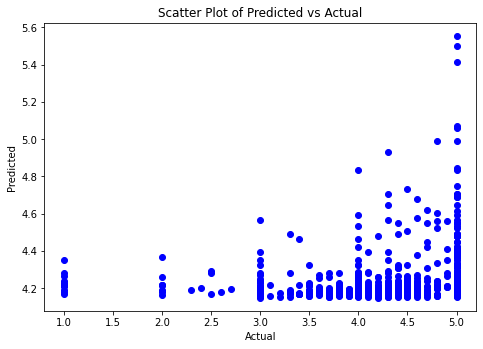

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(y, lr.predict(X), color='b')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Scatter Plot of Predicted vs Actual')
plt.show()

<AxesSubplot:ylabel='Count'>

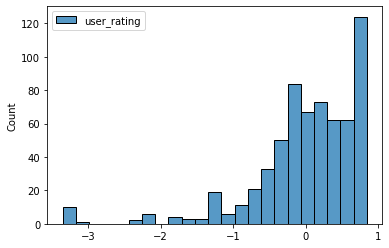

In [32]:
y_residuals = df[['user_rating']] - lr.predict(X)
sns.histplot(data=y_residuals)

#### Challenge 3
Repeat the process of Challenge 1, but add a categorical feature (like genre). You'll have to convert a column of text into a number of numerical columns ("dummy variables"). How can you interpret what's happening in the model?

In [33]:
# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df[['target_mean', 'price', 'country']]

# Choose the response variable(s)
y = df[['user_rating']]

In [34]:
cat_variables = ['country']

X_cat = df[cat_variables]

In [35]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_cat) 
cats = ohe.transform(X_cat)

In [36]:
columns = ohe.get_feature_names(cat_variables)
X_cat_df = pd.DataFrame(cats, columns=columns, index=X_cat.index)
X_cat_df.head()

,country_France,country_Ireland,country_Japan,country_Mexico,country_Scotland,country_Taiwan,country_United States
620,0.0,0.0,0.0,0.0,1.0,0.0,0.0
871,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1068,0.0,0.0,0.0,0.0,1.0,0.0,0.0
488,0.0,0.0,0.0,0.0,1.0,0.0,0.0
996,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [37]:
X_cont = df[['target_mean', 'price']]

X_cont.head()

,target_mean,price
620,4.253822,149.99
871,4.253822,69.99
1068,4.253822,54.99
488,4.253822,149.99
996,4.253822,179.99


In [38]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_cont)
X_scaled = ss.transform(X_cont)

cont_columns = X_cont.columns
X_scaled_df = pd.DataFrame(X_scaled, columns=cont_columns, index=X_cont.index)

X_scaled_df.head()

,target_mean,price
620,0.0,0.621185
871,0.0,-0.097713
1068,0.0,-0.232506
488,0.0,0.621185
996,0.0,0.890771


In [39]:
X_combined = pd.concat([X_cat_df, X_scaled_df], axis='columns')

X_combined.head()

,country_France,country_Ireland,country_Japan,country_Mexico,country_Scotland,country_Taiwan,country_United States,target_mean,price
620,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.621185
871,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.097713
1068,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.232506
488,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.621185
996,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.890771


In [40]:
lr = LinearRegression()

lr.fit(X_combined, y)

y_pred = lr.predict(X_combined)

y_pred

lr.score(X_combined, y)

0.058715179488342706

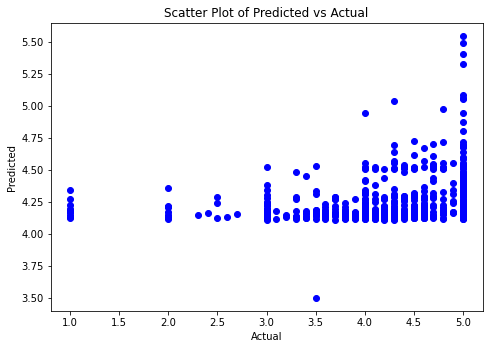

In [41]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(y, y_pred, color='b')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Scatter Plot of Predicted vs Actual')
plt.show()

<AxesSubplot:ylabel='Count'>

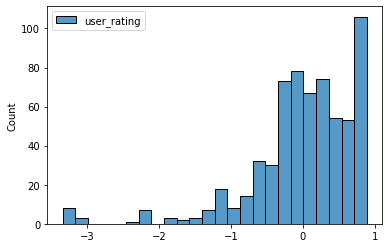

In [42]:
y_residuals = y - y_pred
sns.histplot(data=y_residuals)

#### Challenge 4
Enhance your model further by adding more features and/or transforming existing features. Think about how you build the model matrix and how to interpret what the model is doing.

In [43]:
# The first three predictor variables are continuous and the last three are categorical
X = df[['target_mean', 'num_reviews', 'price', 'brand', 'country', 'spirit_type']]

# Choose the response variable(s)
y = df[['user_rating']]

In [44]:
cat_variables = ['brand', 'country', 'spirit_type']

X_cat = df[cat_variables]

In [45]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_cat) 
cats = ohe.transform(X_cat)

In [46]:
columns = ohe.get_feature_names(cat_variables)
X_cat_df = pd.DataFrame(cats, columns=columns, index=X_cat.index)
X_cat_df.head()

,brand_1792,brand_3 Howls,brand_Abasolo,brand_Agitator,brand_Ainsley Brae,brand_Akashi,brand_Alexander Murray,brand_Ambros,brand_American Pride,brand_Angel's Envy,...,country_Mexico,country_Scotland,country_Taiwan,country_United States,spirit_type_Bourbon,spirit_type_Canadian Whisky,spirit_type_Irish Whiskey,spirit_type_Other Imported Whiskey,spirit_type_Scotch,spirit_type_White Whiskey/Moonshine
620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [47]:
X_cont = df[['target_mean', 'num_reviews', 'price']]

X_cont.head()

,target_mean,num_reviews,price
620,4.253822,1.0,149.99
871,4.253822,1.0,69.99
1068,4.253822,1.0,54.99
488,4.253822,2.0,149.99
996,4.253822,1.0,179.99


In [48]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_cont)
X_scaled = ss.transform(X_cont)

cont_columns = X_cont.columns
X_scaled_df = pd.DataFrame(X_scaled, columns=cont_columns, index=X_cont.index)

X_scaled_df.head()

,target_mean,num_reviews,price
620,0.0,-0.124444,0.621185
871,0.0,-0.124444,-0.097713
1068,0.0,-0.124444,-0.232506
488,0.0,-0.120399,0.621185
996,0.0,-0.124444,0.890771


In [49]:
X_combined = pd.concat([X_cat_df, X_scaled_df], axis='columns')

X_combined.head()

,brand_1792,brand_3 Howls,brand_Abasolo,brand_Agitator,brand_Ainsley Brae,brand_Akashi,brand_Alexander Murray,brand_Ambros,brand_American Pride,brand_Angel's Envy,...,country_United States,spirit_type_Bourbon,spirit_type_Canadian Whisky,spirit_type_Irish Whiskey,spirit_type_Other Imported Whiskey,spirit_type_Scotch,spirit_type_White Whiskey/Moonshine,target_mean,num_reviews,price
620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.124444,0.621185
871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.124444,-0.097713
1068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.124444,-0.232506
488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.120399,0.621185
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.124444,0.890771


In [50]:
lr = LinearRegression()

lr.fit(X_combined, y)

y_pred = lr.predict(X_combined)

y_pred

lr.score(X_combined, y)

0.5527943138241374

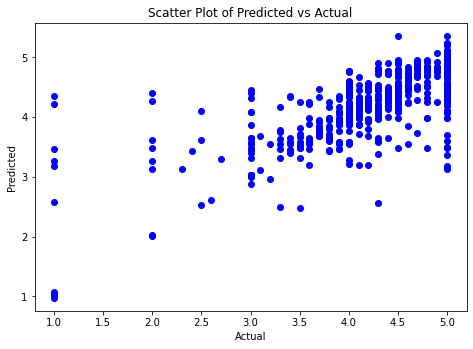

In [51]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(y, y_pred, color='b')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Scatter Plot of Predicted vs Actual')
plt.show()

<AxesSubplot:ylabel='Count'>

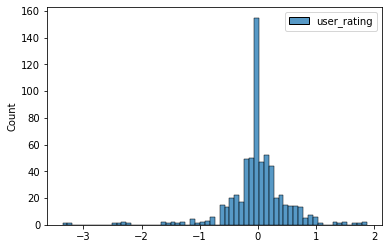

In [52]:
y_residuals = y - y_pred
sns.histplot(data=y_residuals)

#### Challenge 5
Fitting and checking predictions on the exact same data set can be misleading. Divide your data into two sets: a training and a test set (roughly 75% training, 25% test is a fine split). Fit a model on the training set, check the predictions (by plotting versus actual values) in the test set.

In [53]:
from sklearn.model_selection import train_test_split

# The first three predictor variables are continuous and the last three are categorical
X = df[['target_mean', 'num_reviews', 'price', 'brand', 'country', 'spirit_type']]

# Choose the response variable(s)
y = df[['user_rating']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [54]:
cat_variables = ['brand', 'country', 'spirit_type']

X_train_cat = X_train[cat_variables]

In [55]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(X_train_cat) 
cats = ohe.transform(X_train_cat)

In [56]:
columns = ohe.get_feature_names(cat_variables)
X_train_cat_df = pd.DataFrame(cats, columns=columns, index=X_train_cat.index)
X_train_cat_df.head()

,brand_12 Foot Beard,brand_1792,brand_3 Howls,brand_Abasolo,brand_Ainsley Brae,brand_Akashi,brand_Alexander Murray,brand_Ambros,brand_American Pride,brand_Angel's Envy,...,country_Scotland,country_Taiwan,country_United States,spirit_type_American Whiskey,spirit_type_Bourbon,spirit_type_Canadian Whisky,spirit_type_Irish Whiskey,spirit_type_Other Imported Whiskey,spirit_type_Scotch,spirit_type_White Whiskey/Moonshine
337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [57]:
X_test_cat = X_test[['brand', 'country', 'spirit_type']]

cats_test = ohe.transform(X_test_cat) # REMEMBER ONLY TRANSFORM ON TEST SET

cat_columns = ohe.get_feature_names(['brand', 'country', 'spirit_type'])
X_test_cat_df = pd.DataFrame(cats_test, columns=cat_columns, index=X_test_cat.index)
X_test_cat_df.head()

,brand_12 Foot Beard,brand_1792,brand_3 Howls,brand_Abasolo,brand_Ainsley Brae,brand_Akashi,brand_Alexander Murray,brand_Ambros,brand_American Pride,brand_Angel's Envy,...,country_Scotland,country_Taiwan,country_United States,spirit_type_American Whiskey,spirit_type_Bourbon,spirit_type_Canadian Whisky,spirit_type_Irish Whiskey,spirit_type_Other Imported Whiskey,spirit_type_Scotch,spirit_type_White Whiskey/Moonshine
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [58]:
X_train_cont = X_train[['target_mean', 'num_reviews', 'price']]

X_train_cont.head()

,target_mean,num_reviews,price
337,4.253822,3.0,249.99
221,4.253822,4.0,129.99
287,4.253822,4.0,62.99
236,4.253822,32.0,59.99
1157,4.253822,131.0,79.99


In [59]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()

,target_mean,num_reviews,price
337,0.0,-0.375243,1.483647
221,0.0,-0.353003,0.411656
287,0.0,-0.353003,-0.186872
236,0.0,0.269698,-0.213672
1157,0.0,2.471394,-0.035007


In [60]:
X_test_cont = X_test[['target_mean', 'num_reviews', 'price']]

X_test_cont.head()

,target_mean,num_reviews,price
33,4.253822,93.0,29.99
93,4.253822,82.0,54.99
1142,4.253822,67.0,26.99
417,4.253822,1.0,49.99
55,4.253822,20.0,39.99


In [61]:
ss.fit(X_test_cont)

X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,target_mean,num_reviews,price
33,-1.0,0.053147,-0.384194
93,-1.0,0.030483,-0.154386
1142,-1.0,-0.000422,-0.411771
417,-1.0,-0.136406,-0.200347
55,-1.0,-0.097259,-0.292271


In [62]:
X_train_combined = pd.concat([X_train_cat_df, X_train_scaled_df], axis='columns')

X_train_combined.head()

,brand_12 Foot Beard,brand_1792,brand_3 Howls,brand_Abasolo,brand_Ainsley Brae,brand_Akashi,brand_Alexander Murray,brand_Ambros,brand_American Pride,brand_Angel's Envy,...,spirit_type_American Whiskey,spirit_type_Bourbon,spirit_type_Canadian Whisky,spirit_type_Irish Whiskey,spirit_type_Other Imported Whiskey,spirit_type_Scotch,spirit_type_White Whiskey/Moonshine,target_mean,num_reviews,price
337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.375243,1.483647
221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.353003,0.411656
287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.353003,-0.186872
236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.269698,-0.213672
1157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.471394,-0.035007


In [63]:
X_test_combined = pd.concat([X_test_cat_df, X_test_scaled_df], axis='columns')

X_test_combined.head()

,brand_12 Foot Beard,brand_1792,brand_3 Howls,brand_Abasolo,brand_Ainsley Brae,brand_Akashi,brand_Alexander Murray,brand_Ambros,brand_American Pride,brand_Angel's Envy,...,spirit_type_American Whiskey,spirit_type_Bourbon,spirit_type_Canadian Whisky,spirit_type_Irish Whiskey,spirit_type_Other Imported Whiskey,spirit_type_Scotch,spirit_type_White Whiskey/Moonshine,target_mean,num_reviews,price
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.053147,-0.384194
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.030483,-0.154386
1142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.000422,-0.411771
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.136406,-0.200347
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.097259,-0.292271


In [64]:
lr = LinearRegression()

lr.fit(X_train_combined, y_train)

y_pred = lr.predict(X_test_combined)

y_pred

array([[ 4.11718750e+00],
       [ 3.99218750e+00],
       [ 4.32031250e+00],
       [ 2.95703125e+00],
       [ 4.28515625e+00],
       [ 2.97265625e+00],
       [-1.14231925e+11],
       [-1.14231925e+11],
       [ 3.96093750e+00],
       [ 4.39843750e+00],
       [ 4.27343750e+00],
       [ 4.22265625e+00],
       [ 4.78906250e+00],
       [ 4.18359375e+00],
       [ 3.96875000e+00],
       [-1.14231925e+11],
       [ 4.45312500e+00],
       [-1.14231925e+11],
       [ 4.12500000e+00],
       [ 4.32421875e+00],
       [ 3.69140625e+00],
       [ 4.10156250e+00],
       [ 4.25390625e+00],
       [ 4.28906250e+00],
       [-1.14231925e+11],
       [ 4.05859375e+00],
       [-1.14231925e+11],
       [ 4.54687500e+00],
       [ 4.55078125e+00],
       [ 4.88281250e+00],
       [ 4.57031250e+00],
       [ 4.28906250e+00],
       [ 4.45312500e+00],
       [ 4.12109375e+00],
       [ 3.56105011e+12],
       [ 3.56105011e+12],
       [ 3.57031250e+00],
       [ 3.56105011e+12],
       [ 3.9

In [65]:
score = lr.score(X_test_combined, y_test) 
score

-7.456192375397667e+24

In [66]:
lr.score(X_train_combined, y_train)

0.6161913934746073

The score for the training set is greater than the test set, which means that the data is very overfit!

In [67]:
feature_names = X_test_combined.columns

coefficient_values = np.round(lr.coef_, 3)

feats_values = list(zip(feature_names, coefficient_values)) 

sorted(feats_values, key=lambda x: x[1])

[('brand_12 Foot Beard',
  array([ 1.14231925e+11,  1.14231925e+11,  1.14231925e+11, -7.93214920e+12,
         -3.56105011e+12, -1.66953319e+13, -3.56105011e+12,  1.14231925e+11,
          1.14231925e+11,  1.14231925e+11, -3.56105011e+12,  1.14231925e+11,
          1.14231925e+11,  1.14231925e+11,  1.14231925e+11, -3.56105011e+12,
         -3.56105011e+12, -3.56105011e+12, -3.56105011e+12,  1.14231925e+11,
          1.14231925e+11,  1.14231925e+11, -3.56105011e+12,  1.14231925e+11,
         -3.56105011e+12,  1.14231925e+11, -3.60355123e+13, -3.56105011e+12,
          1.14231925e+11,  1.14231925e+11,  1.14231925e+11,  1.14231925e+11,
          1.14231925e+11,  1.14231925e+11,  1.14231925e+11,  1.14231925e+11,
          1.14231925e+11,  1.14231925e+11, -3.56105011e+12,  1.14231925e+11,
          1.14231925e+11,  1.14231925e+11, -1.16978176e+13,  1.14231925e+11,
         -1.16978176e+13,  1.14231925e+11, -3.56105011e+12,  1.14231925e+11,
          1.14231925e+11, -3.56105011e+12,  1.14231

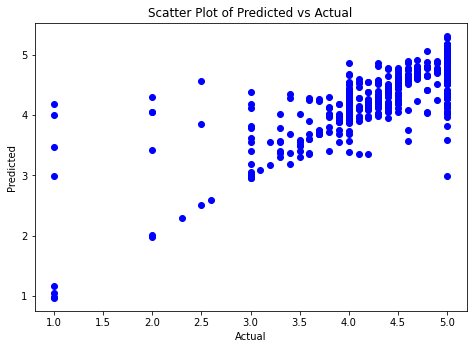

In [68]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(y_train, lr.predict(X_train_combined), color='b')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Scatter Plot of Predicted vs Actual')
plt.show()

#### LASSO

In [69]:
#Separate our features from our target

X = df.loc[:,['num_reviews', 'price', 'brand', 'country', 'spirit_type']]

y = df['user_rating']

# create overall quality squared term, which we expect to 
# help based on the relationship we see in the pair plot 
X['price_squared'] = X['price'] ** 2

In [70]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 620 to 193
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_reviews    641 non-null    float64
 1   price          641 non-null    float64
 2   brand          641 non-null    object 
 3   country        641 non-null    object 
 4   spirit_type    641 non-null    object 
 5   price_squared  641 non-null    float64
dtypes: float64(3), object(3)
memory usage: 35.1+ KB


In [71]:
#Split the data 60 - 20 - 20 train/val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [72]:
X_train.columns

Index(['num_reviews', 'price', 'brand', 'country', 'spirit_type',
       'price_squared'],
      dtype='object')

In [73]:
X_train.shape

(384, 6)

In [74]:
X_val.shape

(128, 6)

In [75]:
X_test.shape

(129, 6)

In [76]:
from sklearn.preprocessing import OneHotEncoder

cat_variables = ['brand', 'country', 'spirit_type']
X_train_cat = X_train[cat_variables]

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(X_train_cat) 
cats = ohe.transform(X_train_cat)

In [77]:
columns = ohe.get_feature_names(cat_variables)
X_train_cat_df = pd.DataFrame(cats, columns=columns, index=X_train_cat.index)
X_train_cat_df.head()

,brand_1792,brand_3 Howls,brand_Abasolo,brand_Ainsley Brae,brand_Akashi,brand_Alexander Murray,brand_Ambros,brand_American Pride,brand_Angel's Envy,brand_Annasach,...,country_Scotland,country_Taiwan,country_United States,spirit_type_American Whiskey,spirit_type_Bourbon,spirit_type_Canadian Whisky,spirit_type_Irish Whiskey,spirit_type_Other Imported Whiskey,spirit_type_Scotch,spirit_type_White Whiskey/Moonshine
255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
X_train_cat_df.shape

(384, 228)

In [79]:
X_test_cat = X_test[['brand', 'country', 'spirit_type']]

cats_test = ohe.transform(X_test_cat) # REMEMBER ONLY TRANSFORM ON TEST SET

cat_columns = ohe.get_feature_names(['brand', 'country', 'spirit_type'])
X_test_cat_df = pd.DataFrame(cats_test, columns=cat_columns, index=X_test_cat.index)
X_test_cat_df.head()

,brand_1792,brand_3 Howls,brand_Abasolo,brand_Ainsley Brae,brand_Akashi,brand_Alexander Murray,brand_Ambros,brand_American Pride,brand_Angel's Envy,brand_Annasach,...,country_Scotland,country_Taiwan,country_United States,spirit_type_American Whiskey,spirit_type_Bourbon,spirit_type_Canadian Whisky,spirit_type_Irish Whiskey,spirit_type_Other Imported Whiskey,spirit_type_Scotch,spirit_type_White Whiskey/Moonshine
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [80]:
X_val_cat = X_val[['brand', 'country', 'spirit_type']]

cats_val = ohe.transform(X_val_cat) # REMEMBER ONLY TRANSFORM ON TEST SET

cat_columns = ohe.get_feature_names(['brand', 'country', 'spirit_type'])
X_val_cat_df = pd.DataFrame(cats_val, columns=cat_columns, index=X_val_cat.index)
X_val_cat_df.head()

,brand_1792,brand_3 Howls,brand_Abasolo,brand_Ainsley Brae,brand_Akashi,brand_Alexander Murray,brand_Ambros,brand_American Pride,brand_Angel's Envy,brand_Annasach,...,country_Scotland,country_Taiwan,country_United States,spirit_type_American Whiskey,spirit_type_Bourbon,spirit_type_Canadian Whisky,spirit_type_Irish Whiskey,spirit_type_Other Imported Whiskey,spirit_type_Scotch,spirit_type_White Whiskey/Moonshine
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [81]:
X_train_cont = X_train[['num_reviews', 'price']]

X_train_cont.head()

,num_reviews,price
255,5.0,23.99
135,39.0,32.99
155,12.0,32.99
446,1.0,26.99
1099,46.0,23.99


In [82]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()

,num_reviews,price
255,-0.302676,-0.545259
135,0.350288,-0.466931
155,-0.168242,-0.466931
446,-0.379496,-0.519150
1099,0.484722,-0.545259


In [83]:
X_test_cont = X_test[['num_reviews', 'price']]

X_test_cont.head()

,num_reviews,price
33,93.0,29.99
93,82.0,54.99
1142,67.0,26.99
417,1.0,49.99
55,20.0,39.99


In [84]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,num_reviews,price
33,1.387349,-0.493040
93,1.176096,-0.275462
1142,0.888024,-0.519150
417,-0.379496,-0.318978
55,-0.014604,-0.406009


In [85]:
X_val_cont = X_val[['num_reviews', 'price']]

X_val_cont.head()

,num_reviews,price
92,149.0,16.49
521,1.0,26.99
706,1.0,54.99
605,1.0,52.99
601,1.0,53.99


In [86]:
X_val_scaled = ss.transform(X_val_cont)

cont_columns = X_test_cont.columns
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=cont_columns, index=X_val_cont.index)

X_val_scaled_df.head()

,num_reviews,price
92,2.462820,-0.610532
521,-0.379496,-0.519150
706,-0.379496,-0.275462
605,-0.379496,-0.292869
601,-0.379496,-0.284165


In [87]:
X_train_combined = pd.concat([X_train_cat_df, X_train_scaled_df], axis='columns')

X_train_combined.head()

X_train_combined.shape

(384, 230)

In [88]:
X_test_combined = pd.concat([X_test_cat_df, X_test_scaled_df], axis='columns')

X_test_combined.head()

,brand_1792,brand_3 Howls,brand_Abasolo,brand_Ainsley Brae,brand_Akashi,brand_Alexander Murray,brand_Ambros,brand_American Pride,brand_Angel's Envy,brand_Annasach,...,country_United States,spirit_type_American Whiskey,spirit_type_Bourbon,spirit_type_Canadian Whisky,spirit_type_Irish Whiskey,spirit_type_Other Imported Whiskey,spirit_type_Scotch,spirit_type_White Whiskey/Moonshine,num_reviews,price
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.387349,-0.493040
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.176096,-0.275462
1142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.888024,-0.519150
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.379496,-0.318978
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.014604,-0.406009


In [89]:
X_val_combined = pd.concat([X_val_cat_df, X_val_scaled_df], axis='columns')

X_val_combined.head()

,brand_1792,brand_3 Howls,brand_Abasolo,brand_Ainsley Brae,brand_Akashi,brand_Alexander Murray,brand_Ambros,brand_American Pride,brand_Angel's Envy,brand_Annasach,...,country_United States,spirit_type_American Whiskey,spirit_type_Bourbon,spirit_type_Canadian Whisky,spirit_type_Irish Whiskey,spirit_type_Other Imported Whiskey,spirit_type_Scotch,spirit_type_White Whiskey/Moonshine,num_reviews,price
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.462820,-0.610532
521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.379496,-0.519150
706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.379496,-0.275462
605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.379496,-0.292869
601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.379496,-0.284165


In [90]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train_combined, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [91]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

0.015167168884709226

In [92]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

[('num_reviews', 0.0),
 ('price', -0.0),
 ('brand', 0.0),
 ('country', -0.0),
 ('spirit_type', 0.0),
 ('price_squared', -0.0)]

In [93]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_test_combined)

In [94]:
lasso_model.score(X_train_combined, y_train)

0.04723188977990167

In [95]:
lasso_model.score(X_test_combined, y_test)

0.03760242104195455

In [96]:
df['brand'].value_counts().head(30)

Battlehill                25
Berry Bros. & Rudd        14
Balcones                  12
Shieldaig                 12
Alexander Murray          12
Grangestone               11
Sugarlands                11
Barrell                   10
Garrison Bros              9
Ellington                  9
Winchester                 9
Macallan                   8
Glen Fohdry                7
Highland Park              7
Jefferson's                7
WhistlePig                 7
Kavanagh                   6
Redemption                 6
Hamiltons                  6
Johnnie Walker             5
Duncan Taylor              5
Jack Daniels               5
Ainsley Brae               5
Tomintoul                  5
Islay Gold                 5
Sagamore Spirit            5
Highland Queen Majesty     5
Barrel and Banter          5
Woodford Reserve           5
MacQueens                  5
Name: brand, dtype: int64

Text(0.5, 1.25, 'User Rating vs. Critic Rating')

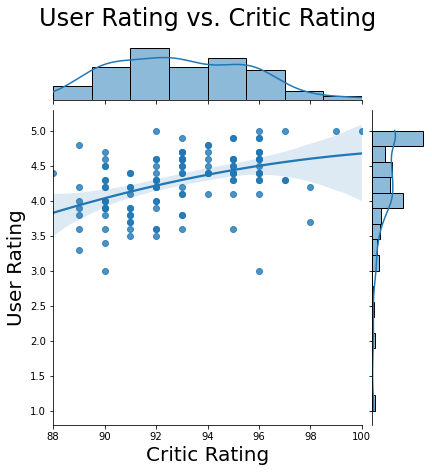

In [97]:
sns.jointplot(x="rating", y="user_rating", data=df, order=2, kind="reg");
plt.xlabel("Critic Rating", size=20)
plt.ylabel("User Rating", size=20)
plt.title("User Rating vs. Critic Rating", size=24, y=1.25)
#plt.savefig('user_rating_vs_rating.svg')

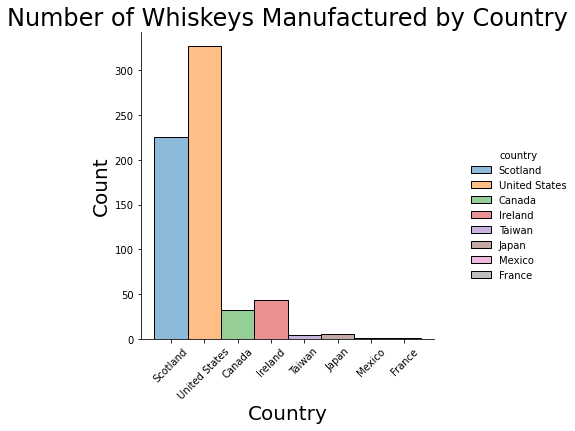

In [98]:
g = sns.displot(df, x='country', binwidth=8, hue='country')
plt.xlabel("Country", size=20)
plt.ylabel("Count", size=20)
plt.title("Number of Whiskeys Manufactured by Country", size=24)
g.set_xticklabels(rotation=45)
#plt.savefig('whiskeys_by_country.svg')